In [1]:
# Manejo de archivos
import os
from pathlib import Path

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

#datetime
from datetime import datetime, timedelta

#outliers 
from pyod.models.mcd import MCD


In [2]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

# Revision variables

In [3]:
raw_folder = Path.cwd().parent / 'data' / 'raw'

In [7]:
df = pd.read_parquet(raw_folder / "df_model.parquet")

In [8]:
df.head()

,velocidad,potencia,per_solidos,celda_carga,rendimiento,flujo_agua,ruido,p80,in14,in12,...,in1,f80,dureza,wi,spi,imp_criticos,imp_estandares,jb,presion_avg,presion_ewm
date,,,,,,,,,,,,,,,,,,,,,
2022-11-15 00:00:00,75.761031,38829.984689,73.39844,78.362584,65.777186,73.931659,15.788181,64.260113,99.98547,99.93459,...,29.857760,39.063374,66.040209,94.815049,54.50695,5.75307,64.40281,0.045367,91.875140,88.832868
2022-11-15 00:00:10,75.761031,38801.377137,72.96875,78.673050,65.561138,74.949818,15.428343,64.260113,99.99471,99.97040,...,30.130893,39.063374,66.040209,94.815049,54.50695,5.75307,64.40281,0.043414,92.364275,89.271139
2022-11-15 00:00:20,75.761031,38168.832363,72.57031,78.973500,64.127962,75.815971,15.428343,64.260113,99.99471,99.97040,...,30.130893,39.063374,66.040209,94.815049,54.50695,5.75307,64.40281,0.041364,93.021432,89.849212
2022-11-15 00:00:30,75.761031,39007.987239,72.55859,78.973500,63.999458,75.815971,14.517244,64.260113,99.99471,99.97040,...,30.130893,35.656382,66.040209,94.815049,54.50695,5.75307,64.40281,0.039330,92.073034,89.613041
2022-11-15 00:00:40,75.684350,38731.447564,72.55859,79.223876,66.060989,75.815971,14.517244,64.260113,99.99544,99.97289,...,28.725894,35.479188,66.040209,94.815049,54.50695,5.75307,64.40281,0.037073,92.166380,89.520688


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 221771 entries, 2022-11-15 00:00:00 to 2022-12-15 00:00:00
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   velocidad       221771 non-null  float64
 1   potencia        221771 non-null  float64
 2   per_solidos     221771 non-null  float64
 3   celda_carga     221771 non-null  float64
 4   rendimiento     221771 non-null  float64
 5   flujo_agua      221771 non-null  float64
 6   ruido           221771 non-null  float64
 7   p80             221771 non-null  float64
 8   in14            221771 non-null  float64
 9   in12            221771 non-null  float64
 10  in10            221771 non-null  float64
 11  in8             221771 non-null  float64
 12  in6             221771 non-null  float64
 13  in4             221771 non-null  float64
 14  in3             221771 non-null  float64
 15  in2_5           221771 non-null  float64
 16  in2             221771

Los datos en esta dataset provienen de sensores instalados en el molino SAG, cada uno de estos datos son guardados aproximadamente cada 10 segundos (podrían ser 8, 12, etc.).

Las variables celda de carga y presión de coginetes son indicadores de que tanta masa hay dentro del molino, los operadores se basan en estas variables para definir que tanto tonelaje deben cargar, que tanto flujo de agua, que velocidad es optima, entre otros, es decir, indican que modo de operación se debe tomar.

La variable celda de carga muestra un comportamiento no muy ideal y con tendenca a descalibraciones, siendo solamente la tendencia la que se toma en cuenta de esta variable. Por otro lado, la variable presión, que resulta de tomar la presión promedio de 8 pads, tiende a ser un mejor indicador en el transcurso de la campaña por su fiabilidad al no descalibrarse con facilidad y al mantener un comportamiento casi identico después de ser calibrado.

Nuestro objetivo es saber si controlando distintas variables del proceso de molienda, podemos controlar o estimar que tanta carga va llevar dentro del molino, para esto nos planteamos el objetivo de desarrollar un modelo de regresión para la variable presion_ewm.

## Relación presion_ewm con celda de carga

In [32]:
df[['presion_ewm', 'celda_carga']].corr()

,presion_ewm,celda_carga
presion_ewm,1.000000,0.872951
celda_carga,0.872951,1.000000


La celda de carga y la presión son dos variables que muestran una correlación alta y en la práctica proporcionan información similar sobre el peso del molino en un momento dado. Ambas variables son indicadores importantes para comprender la carga del molino durante su operación.

Sin embargo, observamos que la celda de carga a veces muestra cambios irreales durante la operación del molino. Estos cambios pueden ser especialmente notables durante los procesos de vaciado, donde la celda de carga puede disminuir hasta mil toneladas respecto a su valor anterior. Esta variabilidad puede generar incertidumbre y dificultar la interpretación precisa de la carga del molino. En realidad, se espera que la carga del molino durante estos procesos caiga aproximadamente entre 200 y 350 toneladas en casos de alta carga. Esto hace que la celda de carga pierda su interpretabilidad de toneladas y se use simplemente como indicador en tendencia, al igual que la presión.

Adicionalmente, la celda de carga tiende a descalibrarse, lo cual hace dificil comparar datos lejanos en tiempo.

Por otro lado, la presión tiende a mostrar un comportamiento más estable y predecible durante la operación del molino, lo que la convierte en un indicador más confiable de la carga del molino en comparación con la celda de carga. Por lo tanto preferimos utilizar la presión como una medida principal de la carga del molino debido a su consistencia y fiabilidad.

Text(0.5, 1.0, 'Relación presión - celda de carga')

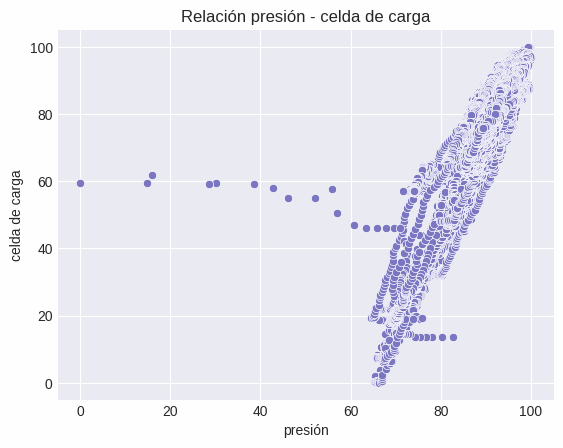

In [34]:
ax = plt.gca()
sns.scatterplot(x = 'presion_ewm',
                y = 'celda_carga',
               data = df)
ax.set_xlabel('presión')
ax.set_ylabel('celda de carga')
ax.set_title('Relación presión - celda de carga')

## Distribución de variables de interes

In [36]:
df.columns

Index(['velocidad', 'potencia', 'per_solidos', 'celda_carga', 'rendimiento',
       'flujo_agua', 'ruido', 'p80', 'in14', 'in12', 'in10', 'in8', 'in6',
       'in4', 'in3', 'in2_5', 'in2', 'in1_5', 'in1', 'f80', 'dureza', 'wi',
       'spi', 'imp_criticos', 'imp_estandares', 'jb', 'presion_avg',
       'presion_ewm'],
      dtype='object')

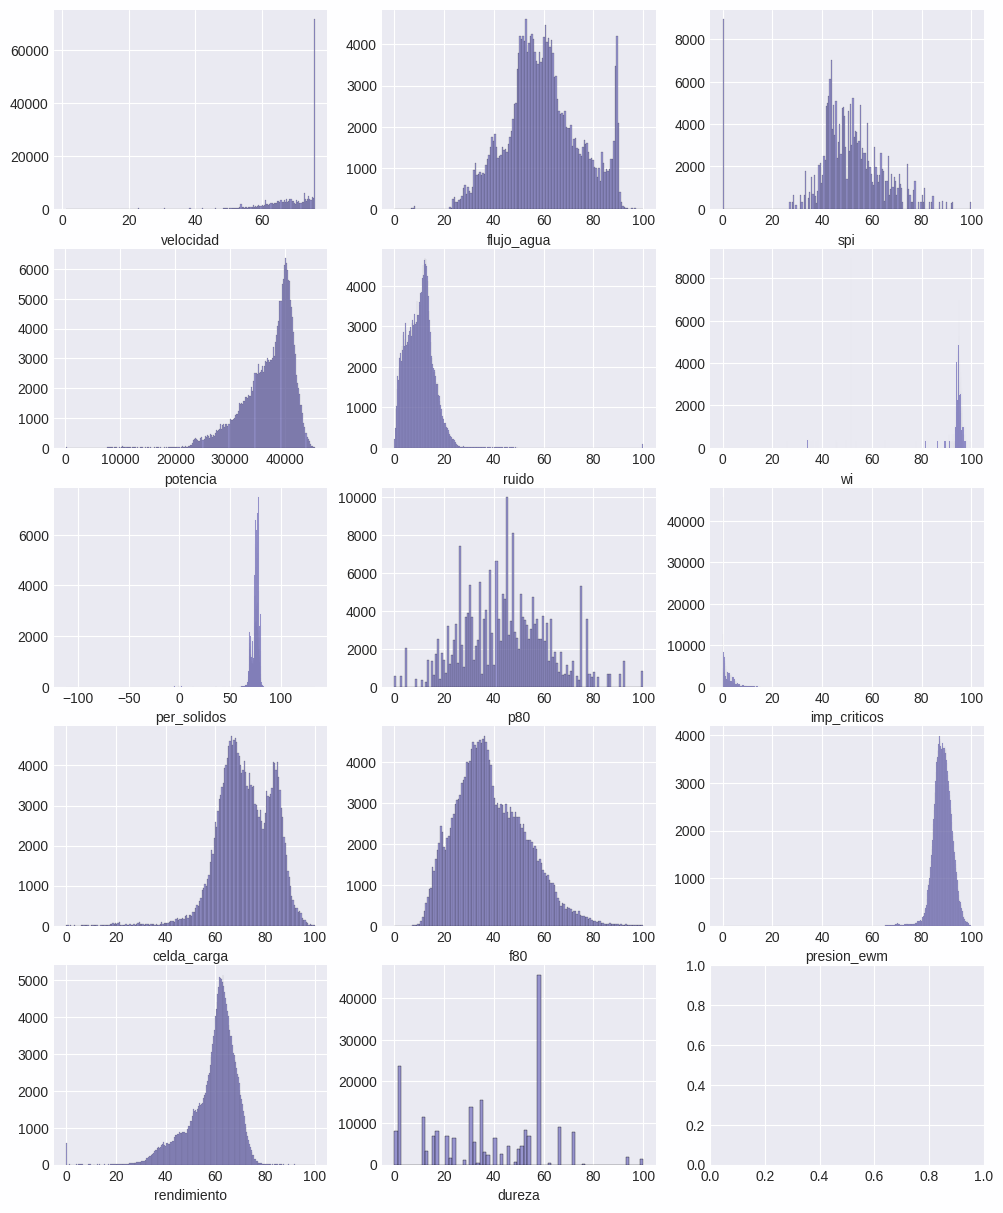

In [45]:
vars_int1 = ['velocidad', 'potencia', 'per_solidos', 'celda_carga', 'rendimiento'] 
vars_int2 = ['flujo_agua', 'ruido', 'p80', 'f80', 'dureza']
vars_int3 = ['spi', 'wi', 'imp_criticos', 'presion_ewm']

fig, axs = plt.subplots(len(vars_int1), 3, figsize = (12, 15))


for var, ax in zip(vars_int1, axs[:,0]):
    sns.histplot(df[var],
                 ax = ax)
    ax.set_ylabel('')

for var, ax in zip(vars_int2, axs[:,1]):
    sns.histplot(df[var],
                 ax = ax)
    ax.set_ylabel('')


for var, ax in zip(vars_int3, axs[:,2]):
    sns.histplot(df[var],
                 ax = ax)
    ax.set_ylabel('')




En el caso de la velocidad vemos que el molino tiene un claro modo de operació y un rango de valores adicionales, los cuales van por ensima del 50% de la velocidad critica.

Las cariables de wi y per_solidos muestran una alta cantidad de outlierscon valores irreales.

## Relacion presión potencia

Una relación concida entre el nivel de llenado del molino y la potencia consumida es que a mayor masa dentro del molino, mayor potencia consumidad.

Aquí veremos que relación vemos de manera directa en los datos. 

Es importante resaltar que no solamente afecta el nivel de carga, si no la densidad aparente de la carga, ya que esta varia de forma sustancial con el nivel de bola que se maneje en cada instante.

In [8]:
#mantener velocidad fija
velocidad_p60 = df['velocidad'].quantile(0.6)
velocidad_max = df.velocidad.max()
print(f"percentil 60 de velocidad {velocidad_p60:.2f}")
print(f"velocidad máxima {velocidad_max:.2f}")

percentil 60 de velocidad 74.23
velocidad máxima 75.91


In [10]:
df_vel_fixed = df[df.velocidad >74.22].copy() #40% de los datos
df_vel_fixed.shape

(88751, 28)

Text(0.5, 1.0, 'celda de carga')

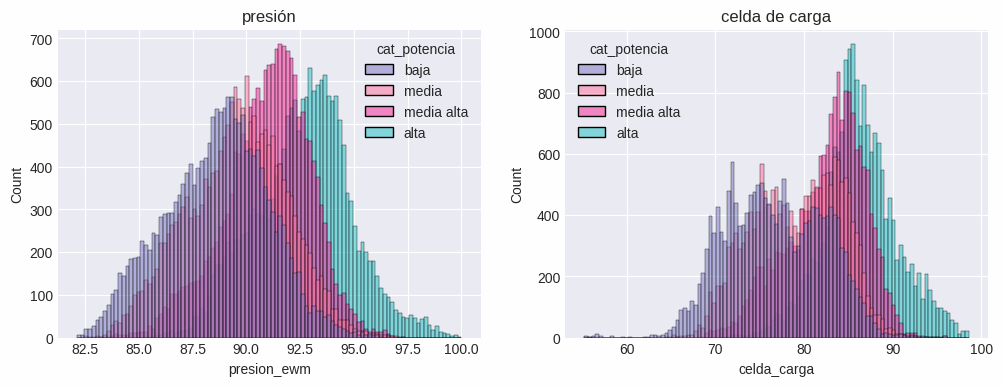

In [11]:
#a mayor carga, mayor consumo de potencia
#u
bins_p = np.quantile(df_vel_fixed.potencia, [0.2, 0.4, 0.6, 0.8, 1])
df_vel_fixed['cat_potencia'] = pd.cut(df_vel_fixed.potencia, 
                                      bins = bins_p,
                                     labels = ['baja', 'media', 'media alta', 'alta'])

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
sns.histplot(x = 'presion_ewm',
            hue = 'cat_potencia',
            data = df_vel_fixed,
            ax = axs[0])
axs[0].set_title('presión')

sns.histplot(x = 'celda_carga',
            hue = 'cat_potencia',
            data = df_vel_fixed,
            ax = axs[1])
axs[1].set_title('celda de carga')

A mayor potencía se observa que la presión incrementa, lo cual es de esperar dado que el moilino tiene en su interior mayor material que debe de mover.

Este mismo efecto no se ve en la celda de carga, se observa que en potencias bajas tiene una varianza mayor, haciendo notar la descalibración de la misma y la falta de confiabilidad en esta variable como indicador de la masa interna del molino.

## Series de tiempo

<Axes: xlabel='date', ylabel='ruido'>

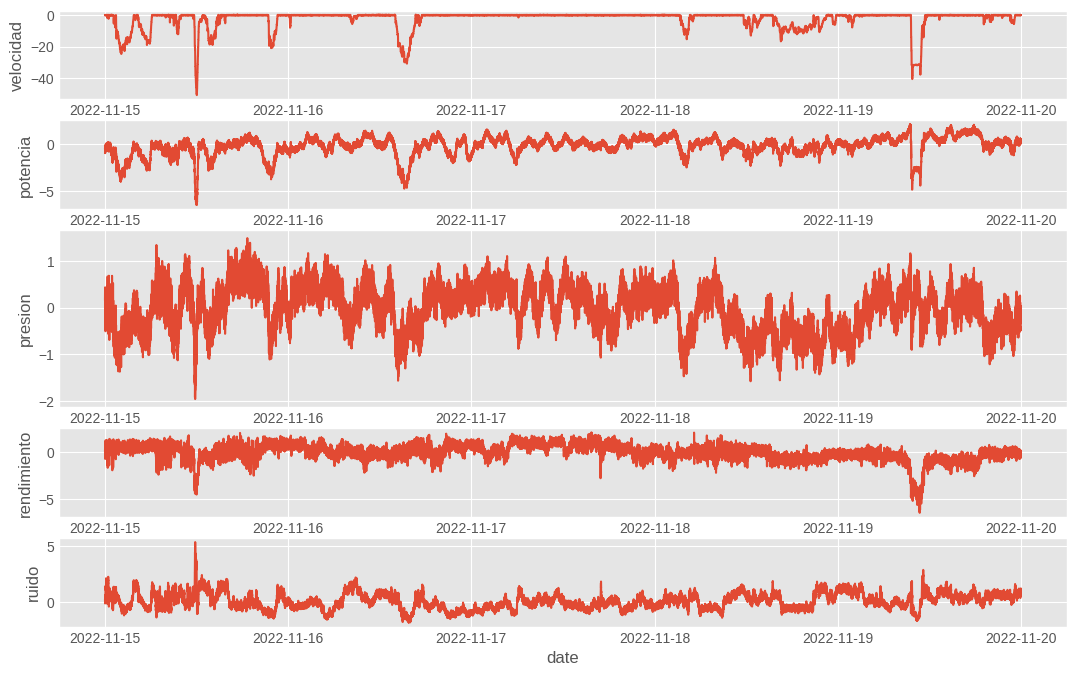

In [86]:
fig, axs = plt.subplots(5, 1, figsize = (13, 8), gridspec_kw = {'height_ratios': [1, 1, 2, 1, 1]})


sns.lineplot(x = 'date',
               y = 'velocidad',
               data = df.reset_index(),
               ax = axs[0])

sns.lineplot(x = 'date',
               y = 'potencia',
               data = df.reset_index(),
               ax = axs[1])

sns.lineplot(x = 'date',
               y = 'presion',
               data = df.reset_index(),
               ax = axs[2])

sns.lineplot(x = 'date',
               y = 'rendimiento',
               data = df.reset_index(),
               ax = axs[3])

sns.lineplot(x = 'date',
               y = 'ruido',
               data = df.reset_index(),
               ax = axs[4])



La variable de velocidad se mantuvo en un solo estado de operación salvo excepciones donde la velocidad no se mantuvo de forma estable. Esta variable juega un papel de gran importante en la carga que se queda dentro del molino, pues al mayor velocidad se obtiene una mayor interacción entre el material y así una mayor eficiencia en el tiempo que transcurre la carga dentro.

La variable de presión tiene un rango saludable y util para el estudio actual, mostrando una variabilidad grande.

# Correlación entre variables

<Axes: >

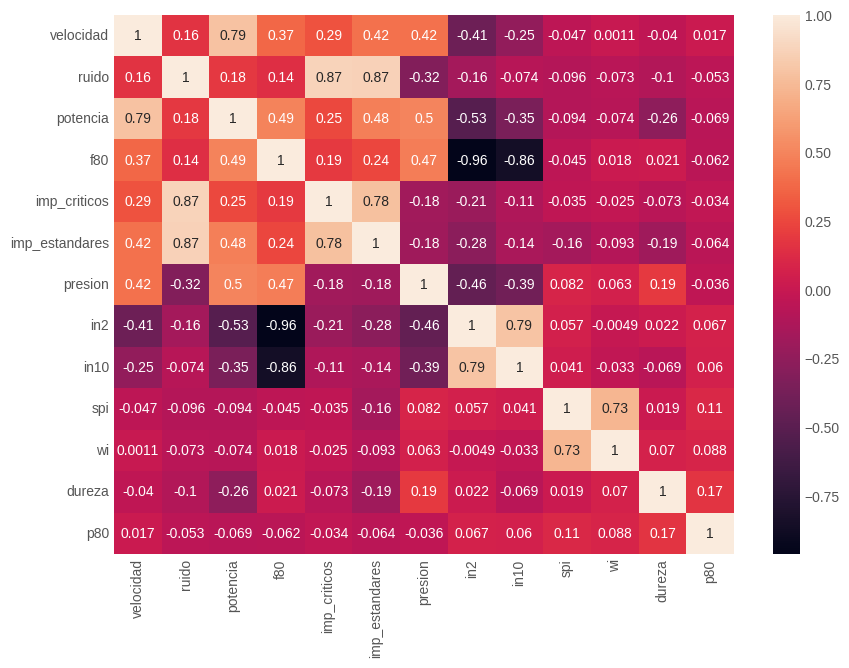

In [118]:
fig, ax = plt.subplots(figsize = (10, 7))

vars_interes = ['velocidad', 'ruido', 'potencia', 'f80', 'imp_criticos', 'imp_estandares', 'presion','in2', 'in10', 'spi', 'wi', 'dureza', 'p80']
sns.heatmap(df[vars_interes].corr(),
            annot = True)

Las correlaciones entre las variables granulometricas es evidente, haciendo ver que el tomar solo una sera suficiente para describir la destribución de roca.

Las variables wi y spi también muestrán una alta correlación, algo de esperar ya que en un sentido miden lo mismo.

De igual manera las variables de sonido como ruido, impactos criticos e impactos estandares muestran una correlación alta.

En general vemos que podemos precindir de bastantes variables.

<Axes: >

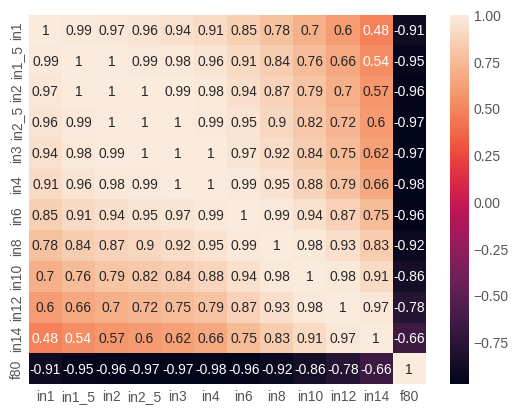

In [110]:
# correlacion entre granulometrias
vars_ = ['in1', 'in1_5', 'in2', 'in2_5', 'in3', 'in4', 'in6', 'in8', 'in10', 'in12', 'in14', 'f80']
sns.heatmap(df[vars_].corr(),
            annot = True)

## 

# Transformación datos a intervalo

La frecuencia de datos debe ser 10 segundos, aunque es normal que haya perdida de datos.

## Rellenos de datos faltantes

In [10]:
#los datos con separación de 20 y 30 segundos se llenenan con un forward fill
df = df.asfreq('10s')
df = df.ffill(limit = 3) #rellenar a lo máximo 30 segundos

In [11]:
#es de esperar que aumente los datos perdidos, los datos originales en lugar de tener
#nan simplemente omite el instante de tiempo en el indice
df.isna().sum() 

velocidad         5337
potencia          5337
per_solidos       5337
celda_carga       5337
rendimiento       5337
flujo_agua        5337
ruido             5337
p80               5337
in14              5337
in12              5337
in10              5337
in8               5337
in6               5337
in4               5337
in3               5337
in2_5             5337
in2               5337
in1_5             5337
in1               5337
f80               5337
dureza            5337
wi                5337
spi               5337
imp_criticos      5337
imp_estandares    5337
jb                5337
presion_avg       5337
presion_ewm       5337
dtype: int64

## Data set de intervalos 8 minutos, con variable objetivo de instante.

Inicialmente se intentara inferir la presión en base a los historicos de 8 minutos (sin incluir la presión).

In [20]:
df.columns

Index(['velocidad', 'potencia', 'per_solidos', 'celda_carga', 'rendimiento',
       'flujo_agua', 'ruido', 'p80', 'in14', 'in12', 'in10', 'in8', 'in6',
       'in4', 'in3', 'in2_5', 'in2', 'in1_5', 'in1', 'f80', 'dureza', 'wi',
       'spi', 'imp_criticos', 'imp_estandares', 'jb', 'presion_avg',
       'presion_ewm'],
      dtype='object')

In [46]:
window_len = 8 * 6 #cada 1 equivale a 10 segundos
vel_column = df.velocidad.rolling(window = window_len).mean().values
pot_column = df.potencia.values
rendimiento_column = df.rendimiento.rolling(window = window_len).mean().values
ruido_column = df.ruido.values
p80_column = df.p80.rolling(window = window_len).mean().values
# in10_column = df.in10.rolling(window = window_len).mean().values
# in1_column = df.in1.rolling(window = window_len).mean().values
f80_column = df.f80.rolling(window = window_len).mean().values
per_solidos_column = df.per_solidos.rolling(window = window_len).mean().values
wi_column = df.wi.rolling(window = window_len).mean().values
spi_column = df.spi.rolling(window = window_len).mean().values
imp_criticos_column = df.imp_criticos.rolling(window = window_len).mean().values
imp_estandares_column = df.imp_estandares.rolling(window = window_len).mean().values
jb_column = df.jb.values
presion = df.presion_ewm.values

In [49]:
df_model = pd.DataFrame({ 'velocidad':vel_column, # promedio
                       'potencia':pot_column, # de instante
                       'rendimiento':rendimiento_column,#promedio
                       'ruido':ruido_column,  #de instante
                       'p80':p80_column, #promedio
                       # 'in10':in10_column, #promedio
                       #  'in1':in1_column, #promedio
                       'f80':f80_column, #promedio
                       'per_solidos':per_solidos_column, #promedio
                       'wi':wi_column, #promedio
                       'spi':spi_column, #promedio
                       'imp_criticos':imp_criticos_column, #instante
                       'imp_estandares':imp_estandares_column, #instante
                       'jb':jb_column, #instante
                       'presion':presion, # de instante
                                 }, index = df.index)
df_model.iloc[window_len:].describe()

,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
count,252081.000000,253816.000000,252081.000000,253816.000000,252081.000000,252081.000000,252081.000000,252081.000000,252081.000000,252081.000000,252081.000000,253816.000000,253816.000000
mean,69.740583,36978.855976,59.173353,10.296211,44.679712,38.732510,75.033211,91.991382,50.564786,2.088734,40.723264,45.117685,88.434510
std,6.645108,4642.517301,8.795686,5.710487,17.330676,13.640006,3.957145,11.822462,14.963863,2.596146,22.362334,29.556527,3.708442
min,22.930270,162.109465,0.014164,0.000000,0.000000,10.736023,1.516407,0.000000,0.000000,0.000000,0.013417,1.238072,0.000000
25%,65.561082,34522.958719,55.474234,6.129741,31.130319,28.745793,73.690959,94.218184,43.681633,0.211431,21.239510,20.958729,86.186706
50%,72.053614,38270.548106,61.316061,10.416884,44.740149,36.989303,75.861206,94.916059,50.499529,1.195863,45.433255,33.542425,88.438755
75%,75.735469,40343.006358,64.842049,13.542739,55.563118,47.896874,77.688924,95.619150,58.376977,3.228022,59.538447,78.752789,90.847922
max,75.820134,45390.650079,75.371860,100.000000,100.000000,91.966382,81.595704,100.000000,100.000000,67.783075,96.318794,100.000000,100.000000


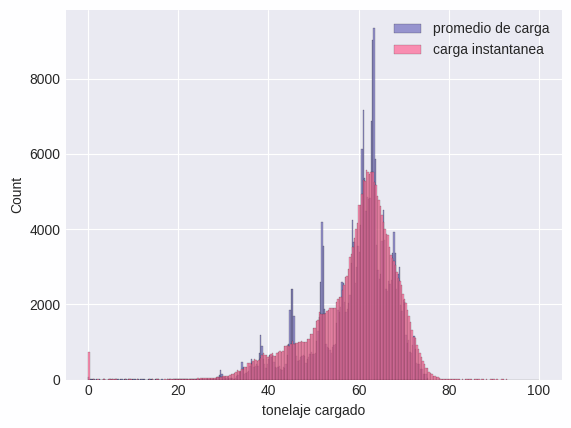

In [50]:
#diferencia entre tonelaje cargado instantaneo vs cada 8 minutos, se pierden las modas
ax = plt.gca()
sns.histplot(df_model.rendimiento,
             label = 'promedio de carga')
sns.histplot(df.rendimiento,
             label = 'carga instantanea')
ax.set_xlabel('tonelaje cargado')
ax.legend()